In [5]:
import numpy as np
import seaborn
import torch
from torchmetrics import ConfusionMatrix
from torchmetrics.classification import BinaryAccuracy
from tqdm import tqdm
from transformers import pipeline

from project.pipeline.balance_data import balance_data_indices_reduction
from project.pipeline.data_loader import DataLoader

In [2]:
classifier = pipeline("zero-shot-classification", device="cuda:0")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [3]:
data_loader = DataLoader(batch_size=16)

predictions = []
labels = []
for batch in tqdm(data_loader):
    text = list(batch["text"].values)
    prediction = classifier(text, candidate_labels=["sexist", "not sexist"])
    prediction = [p["labels"][0] for p in prediction]
    predictions.extend(prediction)

    label = list(batch["label_sexist"].values)
    labels.extend(label)

  1%|          | 10/875 [00:06<08:14,  1.75it/s]/home/akriel/anaconda3/envs/lexicology/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 875/875 [08:47<00:00,  1.66it/s]


In [6]:
target = torch.tensor(np.array([entry != "not sexist" for entry in labels]))
predictions = torch.tensor(np.array([entry != "not sexist" for entry in predictions]))

In [7]:
accuracy_metric = BinaryAccuracy()
confusion_matrix_metric = ConfusionMatrix(num_classes=2)
labels = ["not sexist", "sexist"]

In [8]:
df = data_loader.df
balanced_df_indices = balance_data_indices_reduction(df['label_sexist'])

Accuracy on whole dataset: 0.4173571467399597


<AxesSubplot: >

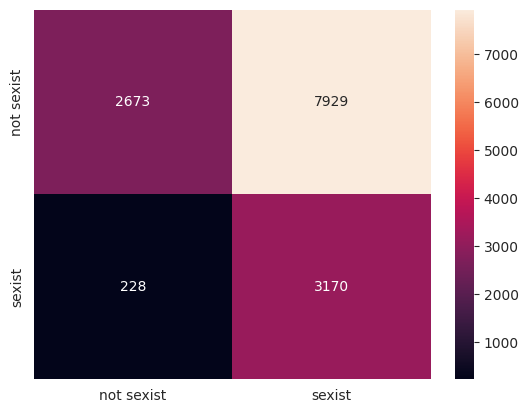

In [9]:
acc = accuracy_metric(predictions, target)
mat = confusion_matrix_metric(predictions, target)
print(f"Accuracy on whole dataset: {acc}")
seaborn.heatmap(mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)

Accuracy on balanced dataset: 0.5919658541679382


<AxesSubplot: >

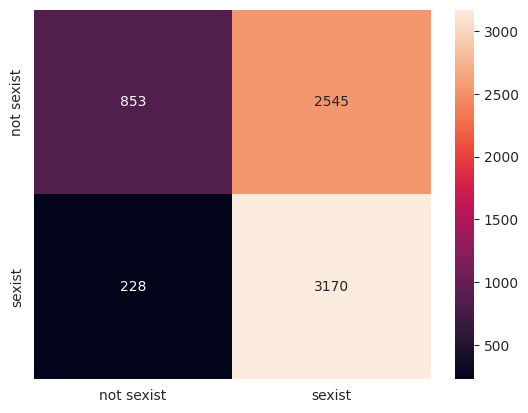

In [10]:
acc = accuracy_metric(predictions[balanced_df_indices], target[balanced_df_indices])
mat = confusion_matrix_metric(predictions[balanced_df_indices], target[balanced_df_indices])
print(f"Accuracy on balanced dataset: {acc}")
seaborn.heatmap(mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)